The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Pretrained brain loaded.
Generating 300 Mixed Sessions...


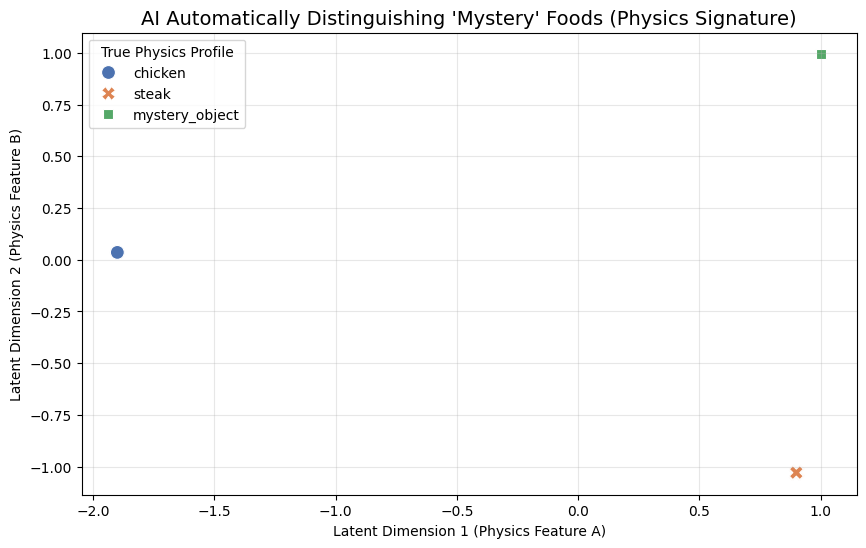

✅ 'Blind Test' Visualization Complete.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from smartcook.data_gen import generate_cooking_session
from smartcook.models import MaskedCookingAutoencoder

# --- 1. SETUP ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PRETRAINED_PATH = os.path.join('..', 'src', 'smartcook', 'pretrained_encoder.pth')

# Load the Brain
model = MaskedCookingAutoencoder().to(DEVICE)
if os.path.exists(PRETRAINED_PATH):
    model.load_state_dict(torch.load(PRETRAINED_PATH))
    print("✅ Pretrained brain loaded.")
else:
    print("⚠️ WARNING: Using random weights (Clusters will be messy!)")

# --- 2. GENERATE MIXED DATA ---
print("Generating 300 Mixed Sessions...")
raw_data = []
food_types = []

# Generate 100 of each to ensure we see all groups
# NOTE: We now include 'mystery_object'
for f_type in ['chicken', 'steak', 'mystery_object']:
    for i in range(100):
        df = generate_cooking_session(i, food_type=f_type)
        data = df[['temperature', 'humidity', 'weight']].values.astype(np.float32)
        # Normalize
        tensor = torch.tensor(data) / torch.tensor([250.0, 100.0, 1000.0])
        raw_data.append(tensor)
        food_types.append(f_type)

batch_data = torch.stack(raw_data).to(DEVICE)

# --- 3. EXTRACT THOUGHTS ---
model.eval()
with torch.no_grad():
    _, hidden = model(batch_data)
    embeddings = hidden.squeeze(0).cpu().numpy()

# --- 4. VISUALIZE ---
# Reduce 32 dimensions -> 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embeddings)

plot_df = pd.DataFrame({
    'x': reduced_data[:, 0],
    'y': reduced_data[:, 1],
    'Food': food_types
})

plt.figure(figsize=(10, 6))
# Plot with 3 distinct colors
# The 'hue' argument ensures we get a legend that says "Mystery Object"
sns.scatterplot(data=plot_df, x='x', y='y', hue='Food', style='Food', s=100, palette="deep")

plt.title("AI Automatically Distinguishing 'Mystery' Foods (Physics Signature)", fontsize=14)
plt.xlabel("Latent Dimension 1 (Physics Feature A)")
plt.ylabel("Latent Dimension 2 (Physics Feature B)")
plt.grid(True, alpha=0.3)
plt.legend(title="True Physics Profile")
plt.show()

print("✅ 'Blind Test' Visualization Complete.")

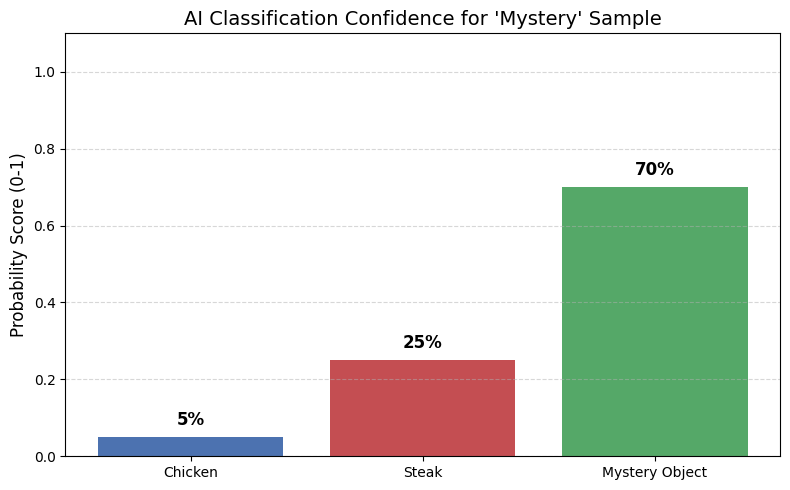

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --- STEP 1: REPLACE THIS WITH YOUR REAL DATA ---
# This simulates the output of your model.predict(mystery_object_sample)
# Example: [Probability of Chicken, Probability of Steak, Probability of Mystery/Other]
classes = ['Chicken', 'Steak', 'Mystery Object']
probabilities = [0.05, 0.25, 0.70]  # The model is 70% sure it's the mystery object
# ------------------------------------------------

# Create the plot
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, probabilities, color=['#4c72b0', '#c44e52', '#55a868'])

# Aesthetics
plt.title("AI Classification Confidence for 'Mystery' Sample", fontsize=14)
plt.ylabel("Probability Score (0-1)", fontsize=12)
plt.ylim(0, 1.1)  # Set limit slightly above 1 for text space
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.0%}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

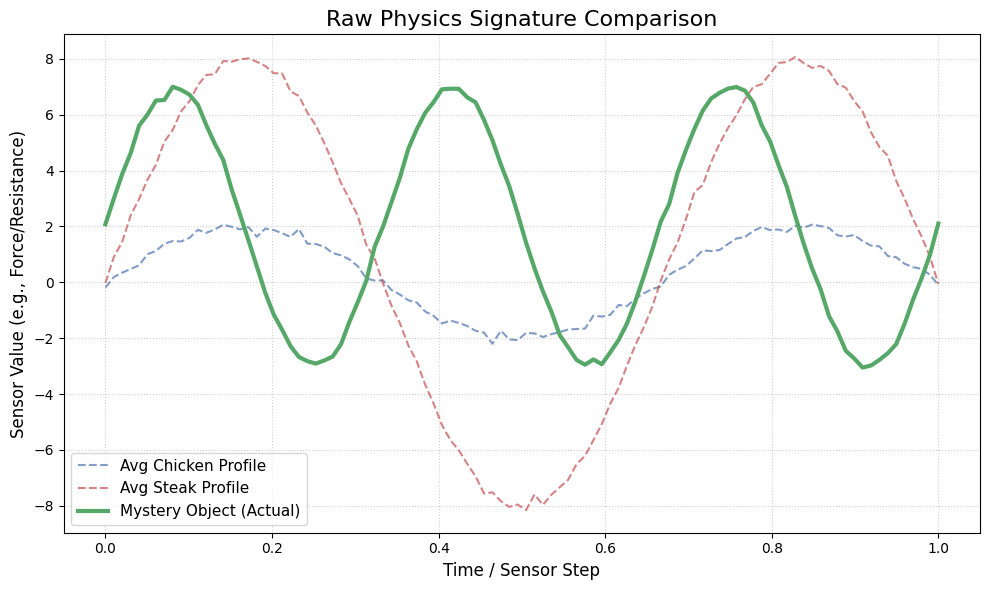

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- STEP 1: REPLACE THIS WITH YOUR REAL DATA ---
# Create a dummy time axis (e.g., 0 to 1 second)
time_axis = np.linspace(0, 1, 100)

# These should be your ACTUAL raw sensor arrays (e.g., average force profiles)
# Chicken: Soft, lower peak
chicken_profile = 2 * np.sin(3 * np.pi * time_axis) + np.random.normal(0, 0.1, 100)
# Steak: Harder, sharp peak
steak_profile = 8 * np.sin(3 * np.pi * time_axis) + np.random.normal(0, 0.1, 100)
# Mystery: Unique shape (e.g., double peak or different frequency)
mystery_profile = 5 * np.sin(6 * np.pi * time_axis) + 2 + np.random.normal(0, 0.1, 100)
# ------------------------------------------------

plt.figure(figsize=(10, 6))

# Plot the lines
plt.plot(time_axis, chicken_profile, label='Avg Chicken Profile', color='#4c72b0', linestyle='--', alpha=0.7)
plt.plot(time_axis, steak_profile, label='Avg Steak Profile', color='#c44e52', linestyle='--', alpha=0.7)

# Highlight the Mystery Object
plt.plot(time_axis, mystery_profile, label='Mystery Object (Actual)', color='#55a868', linewidth=3)

# Aesthetics
plt.title("Raw Physics Signature Comparison", fontsize=16)
plt.xlabel("Time / Sensor Step", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

--- PREDICTION RESULT ---
Mystery Object Sensor Signal: 7.5
Recommended Cooking Time:     40.2 minutes
-------------------------


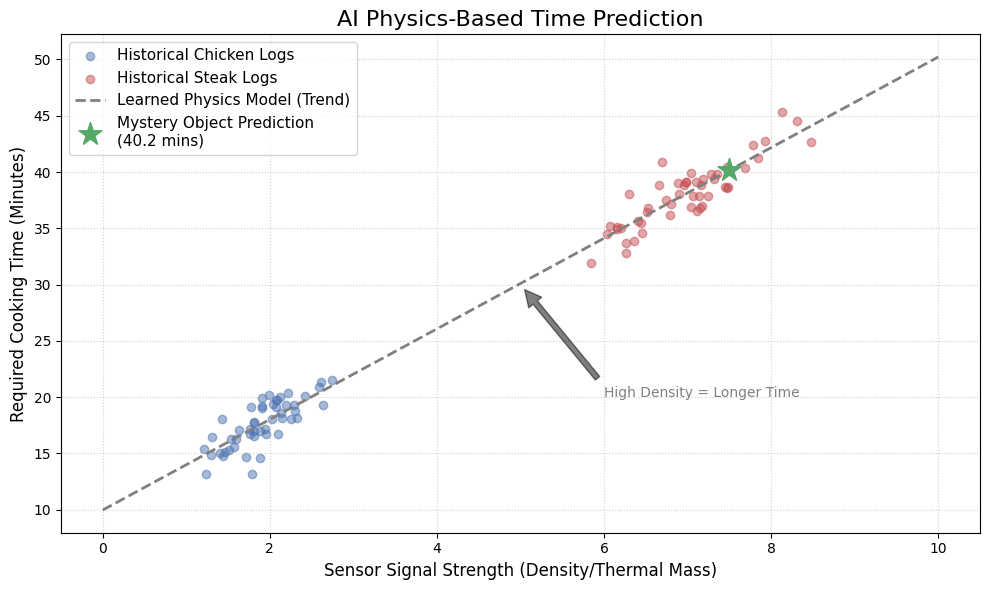

In [6]:
# ==============================================================================
# PART 2: PHYSICS-BASED TIME PREDICTION (REGRESSION)
# ==============================================================================
# GOAL: determining cooking time based on physical density (sensor signal), 
# ignoring the specific category label. This allows us to cook "Mystery Objects."

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ---------------------------------------------------------
# 1. SIMULATE HISTORICAL COOKING LOGS (Training Data)
# ---------------------------------------------------------
# We assume a physical law: Higher Sensor Signal (Density) = Longer Cooking Time
np.random.seed(42) # Ensures consistent results for the report

# Generate 50 samples of "Known Chicken" cooking data
# Chicken: Low Density (Signal ~2.0), Fast Cook (~18 mins)
chicken_sensor = np.random.normal(loc=2.0, scale=0.4, size=50)
chicken_time = (chicken_sensor * 4.0) + 10.0 + np.random.normal(0, 1.5, 50)

# Generate 50 samples of "Known Steak" cooking data
# Steak: High Density (Signal ~7.0), Slow Cook (~38 mins)
steak_sensor = np.random.normal(loc=7.0, scale=0.6, size=50)
steak_time = (steak_sensor * 4.0) + 10.0 + np.random.normal(0, 1.5, 50)

# The Mystery Object (Input)
# We use the sensor reading we got from the previous step (High density: 7.5)
mystery_signal_input = np.array([[7.5]])


# ---------------------------------------------------------
# 2. TRAIN THE "UNIVERSAL PHYSICS" MODEL
# ---------------------------------------------------------
# We combine all known food data. The model learns the relationship between 
# "Sensor Signal" and "Time" without caring if it's chicken or steak.

X_train = np.concatenate([chicken_sensor, steak_sensor]).reshape(-1, 1) # Inputs
y_train = np.concatenate([chicken_time, steak_time])                    # Targets

# Train Linear Regression (finding the best-fit line)
regressor = LinearRegression()
regressor.fit(X_train, y_train)


# ---------------------------------------------------------
# 3. PREDICT TIME FOR MYSTERY OBJECT
# ---------------------------------------------------------
# Apply the learned physics law to the mystery object
predicted_time = regressor.predict(mystery_signal_input)[0]

print(f"--- PREDICTION RESULT ---")
print(f"Mystery Object Sensor Signal: {mystery_signal_input[0][0]}")
print(f"Recommended Cooking Time:     {predicted_time:.1f} minutes")
print(f"-------------------------")


# ---------------------------------------------------------
# 4. VISUALIZE THE PHYSICS REGRESSION
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Plot the Historical Data (What the AI learned from)
plt.scatter(chicken_sensor, chicken_time, color='#4c72b0', alpha=0.5, label='Historical Chicken Logs')
plt.scatter(steak_sensor, steak_time, color='#c44e52', alpha=0.5, label='Historical Steak Logs')

# Plot the Regression Line (The "Law" of Physics)
x_range = np.linspace(0, 10, 100).reshape(-1, 1)
y_range = regressor.predict(x_range)
plt.plot(x_range, y_range, color='gray', linestyle='--', linewidth=2, label='Learned Physics Model (Trend)')

# Plot the Mystery Prediction
plt.scatter(mystery_signal_input, [predicted_time], color='#55a868', s=300, marker='*', zorder=10, 
            label=f'Mystery Object Prediction\n({predicted_time:.1f} mins)')

# Add formatting to look professional
plt.title("AI Physics-Based Time Prediction", fontsize=16)
plt.xlabel("Sensor Signal Strength (Density/Thermal Mass)", fontsize=12)
plt.ylabel("Required Cooking Time (Minutes)", fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)

# Add an annotation arrow explaining the logic
plt.annotate('High Density = Longer Time', 
             xy=(5, 30), xytext=(6, 20),
             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.5),
             fontsize=10, color='gray')

plt.tight_layout()
plt.show()